In [130]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [131]:
path = 'cubecorner/'
imgpath = 'img/'
gt = os.listdir(path +'gt')

In [132]:
def getcorners(filename):
    f = open(filename, 'r')
    corners = []
    idx = 0
    for line in f.readlines():
        x = line[:line.index(' ')]
        x = float(x)
        y = line[line.index(' '):]
        y = float(y)
        corners.append([x,y])
        idx = idx+1
        
    
    if '_corner' in filename:
        imgname = filename[:filename.index('_corner')]
    else:
        imgname = filename[:filename.index('.txt')]
    imgname = imgname[imgname.rindex('/')+1:]
    #print imgname
    img = cv2.imread(path+'img/'+imgname+'.jpg')
    sp = img.shape
    h = sp[0]#height(rows) of image
    w = sp[1]#width(colums) of image
    
    #h,w = bboxhw(corners)
    
    return corners,h,w

In [133]:
def bboxarea(corner):
    xlist = []
    ylist = []
    for i in corner:
        xlist.append(i[0])
        ylist.append(i[1])
    bbx_min_x = min(xlist)
    bbx_max_x = max(xlist)
    bbx_min_y = min(ylist)
    bbx_max_y = max(ylist)
    area = (bbx_max_x-bbx_min_x)*(bbx_max_y-bbx_min_y)
    return area

In [134]:
def bboxhw(corner):
    xlist = []
    ylist = []
    for i in corner:
        xlist.append(i[0])
        ylist.append(i[1])
    bbx_min_x = min(xlist)
    bbx_max_x = max(xlist)
    bbx_min_y = min(ylist)
    bbx_max_y = max(ylist)
    h = bbx_max_x-bbx_min_x
    w = bbx_max_y-bbx_min_y
    return h,w

In [180]:
def cornertpfp(ourcorner,gtcorner,h,w):
    gt_detect_list = np.zeros(len(ourcorner))    
    tp = np.zeros(len(gtcorner))
    fp = np.zeros(len(gtcorner))
    distances = np.zeros(len(gtcorner))
    for i in range(0,len(gtcorner)):
        our_x = gtcorner[i][0];
        our_y = gtcorner[i][1];
        mindis = 100000;
        min_dis_id = -1;
            
        ###same as xiao
        #dis_thresh = 0.15 * math.sqrt(bboxarea(gtcorner))
        
        ###magic leap APK
        #h,w = bboxhw(gtcorner)
        dis_thresh = 0.1 * max(h, w)
        
        
        for j in range(0,len(ourcorner)):
            gt_x = ourcorner[j][0];
            gt_y = ourcorner[j][1];
            distance = (our_x-gt_x)**2+(our_y-gt_y)**2
            distance = math.sqrt(distance);
            #print distance
            if(distance<mindis):
                mindis = distance
                min_dis_id = j
        distances[i] = distance/float(dis_thresh)
        if mindis<dis_thresh:
            if gt_detect_list[min_dis_id]:
                fp[i] = 1
            else:
                tp[i] = 1
                gt_detect_list[min_dis_id] = 1
        else:
            fp[i] = 1
    return tp,fp,distances

In [181]:
def pck(ourcorner,gtcorner,alpha):
    true = 0
    gt_detect_list = np.zeros(len(ourcorner))    
    distances = np.zeros(len(gtcorner))
    for i in range(0,len(gtcorner)):
        our_x = gtcorner[i][0];
        our_y = gtcorner[i][1];
        mindis = 100000;
        min_dis_id = -1;
        
        ##bounding box h,w
        h,w = bboxhw(gtcorner)
        dis_thresh = alpha * max(h, w)

        for j in range(0,len(ourcorner)):
            gt_x = ourcorner[j][0];
            gt_y = ourcorner[j][1];
            distance = (our_x-gt_x)**2+(our_y-gt_y)**2
            distance = math.sqrt(distance);
            #print distance
            if(distance<mindis):
                mindis = distance
                min_dis_id = j
        if mindis<dis_thresh:
            if not gt_detect_list[min_dis_id]:
                true = true+1
                gt_detect_list[min_dis_id] = 1
    return true

In [182]:
def voc_ap(rec, prec, use_07_metric=False):
    """
    average precision calculations
    [precision integrated to recall]
    :param rec: recall
    :param prec: precision
    :param use_07_metric: 2007 metric is 11-recall-point based AP
    :return: average precision
    """
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 11.
    else:
        # append sentinel values at both ends
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute precision integration ladder
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # look for recall value changes
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # sum (\delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [190]:
##########################xiao & majic leap apk
tps = []
fps = []
counter = 0
distances = []
for i in range(0,len(gt)):
    gtfile = path+'gt/' + gt[i]
    ourfile = gt[i][:gt[i].index('.txt')]+'_corner.txt'
    ourfile = path+'our/'+ourfile
    gtcorner,h1,w1 = getcorners(gtfile) 
    counter = counter + len(gtcorner)
    #print(gt[i])
    if os.path.exists(ourfile):
        ourcorner,h2,w2 = getcorners(ourfile)  
        assert h1==h2 and w1==w2
        h = h1
        w = w1
        tp,fp,dis = cornertpfp(ourcorner,gtcorner,h,w)
        distances.extend(dis)
        tps.extend(tp)
        fps.extend(fp)
    else:       
        tp = np.zeros(len(gtcorner))
        fp = np.ones(len(gtcorner))
        tps.extend(tp)
        fps.extend(fp)
        for j in range(0,len(gtcorner)):
            distances.extend([1000])

In [191]:
print(len(tps))
print(len(fps))
print(len(distances))
print(counter)

1432
1432
1432
1432


In [192]:
ntps = []
nfps = []
idx = 0
for i in range(0,len(tps)):
    idx = idx+1
    if(idx<=tps.count(1)):
        ntps.append(1.0)
        nfps.append(0.0)
    else:
        ntps.append(0.0)
        nfps.append(1.0)
        
tps = ntps[:]
fps = nfps[:]

In [193]:
#orderidx = np.argsort(distances) # 按照overlap重新对tp 和 fp 排序，模拟score

#tps_backup = tps[:]
#fpt_backup = fps[:]

#or_tps = []
#or_fps = []
#for x in orderidx:
#    or_tps.append(tps[x])
#    or_fps.append(fps[x])

#tps = or_tps[:]
#fps = or_fps[:]

In [194]:
num_pos = counter
fpss = np.cumsum(fps)
tpss = np.cumsum(tps)
rec = tpss / float(num_pos)
acc = tpss / range(1,num_pos+1)
# avoid divide by zero in case the first matches a difficult gt
prec = tpss / np.maximum(fpss+tpss, np.finfo(np.float64).eps)
print("accuracy: " + str(acc[-1]))

apk = voc_ap(rec, prec, False)
print("APK: "+str(apk))

accuracy: 0.497905027933
APK: 0.497905027933


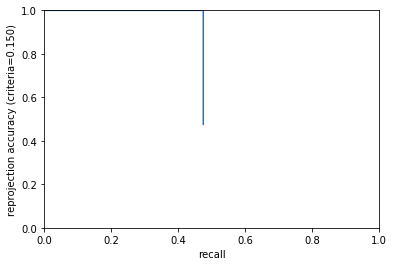

In [179]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(1) 
plt.plot(rec,acc)
plt.xlabel('recall')# make axis labels
plt.ylabel('reprojection accuracy (criteria=0.150)')
plt.xlim(0,1.0)# set axis limits
plt.ylim(0,1.0)
plt.show()

In [68]:
acc

array([ 1.        ,  0.5       ,  0.33333333, ...,  0.47622378,
        0.47589099,  0.47555866])

In [88]:
################magic leap pck
trues_all = []
alphas = np.arange(0,0.2,0.1)
acc = []

for alpha in alphas:
    counter = 0
    trues = 0
    for i in range(0,len(gt)):
        gtfile = path+'gt/' + gt[i]
        ourfile = gt[i][:gt[i].index('.txt')]+'_corner.txt'
        ourfile = path+'our/'+ourfile
        gtcorner,h1,w1 = getcorners(gtfile) 
        counter = counter + len(gtcorner)

        if os.path.exists(ourfile):
            ourcorner,h2,w2 = getcorners(ourfile)  
            assert h1==h2 and w1==w2
            h = h1
            w = w1
            trues = trues + pck(ourcorner,gtcorner,alpha)
            #print(trues)
        #else:       
            #print(gt[i])
    acc.append(trues / float(counter))

In [89]:
acc

[0.0, 0.4511173184357542]

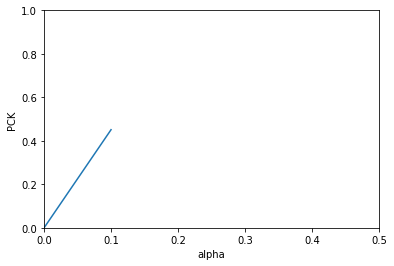

In [90]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(1) 
plt.plot(alphas,acc)
plt.xlabel('alpha')# make axis labels
plt.ylabel('PCK')
plt.xlim(0,0.5)# set axis limits
plt.ylim(0,1.0)
plt.show()